# Nonlinear prediction of chaotic dynamical systems

Assume you observe a time series $(y_1, y_2, \dots, y_T)$ that represents a variable of a high dimensional and possibly chaotic dynamical system.

The method proposed by Sugihara and May (Nature, 1990) entails first choosing an embedding dimension, $n$, and then predicting $y_t$ by using past observations $\vec y_p(t) = (y_{t-1}, y_{t-2}, \dots, y_{t-n}) \in \mathbb{R}^n$. 

Intuitively, the prediction is obtained by finding a set of vectors $\{ \vec y^1_p, \dots, \vec y^n_p \}$ in the past, which are nearest neighbors of $\vec y_p$, and basing future predictions on what occurred immediately after these past events. 

Let's begin with an example.

In [41]:
# simulate Lorenz attractor
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

# standard parameters
rho=28;sigma=10;beta=8/3
def f(X, t):
  x, y, z = X
  return sigma * (y - x), x * (rho - z) - y, x * y - beta * z
# initial value
x0 = np.array([-11.40057002, -14.01987468,  27.49928125])
t = np.arange(0.0, 100, 0.01)
lorenz = odeint(f, x0, t)

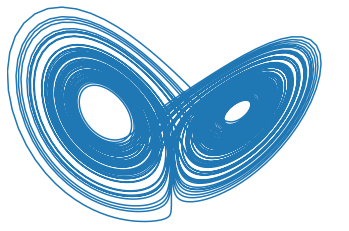

In [54]:
# 3D plot of Lorenz attractor - beautiful!
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(lorenz[:,0], lorenz[:,1], lorenz[:,2])
plt.axis('off')
plt.xlim([-13,14])
plt.ylim([-20,25])
ax.set_zlim([15,38])
plt.show()

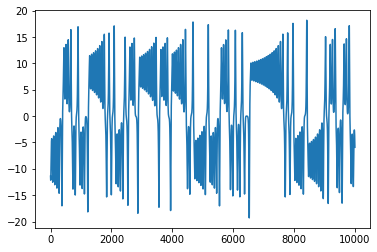

In [55]:
# plot only first component
plt.plot(lorenz[:,0])

#### How can we predict the future of such a chaotic system, given its past??

Many methods have been proposed that are based on Takens (1981) and Sauer (1991) theorems (see: http://www.scholarpedia.org/article/Attractor_reconstruction)

In detail, the method proposed by Sugihara and May (https://www.nature.com/articles/344734a0) works in three steps: 

 ( 1 )  divide your time series $y_1,\dots, y_T$ into train and test. Use train time series as a library of past patterns, i.e., by computing past vectors $\vec y_p(t) = (y_{t-1}, y_{t-2}, \dots, y_{t-n}) \in \mathbb{R}^n$ for each point $t>n$, with associated future value $y_t$.

 ( 2 )  for each test time point $y^*$ compute its past vector $\vec y_p^* = (y_{t^*-1}, y_{t^*-2}, \dots, y_{t^*-n})$, and find the $n+1$ nearest neighbors in the library of past patterns: $\{y_p^1, \dots, y_p^{n+1}\}$ and compute their distance to $y_p^*$: $d_i = || y_p^* - y_p^i||$.

 ( 3 )  predict test time point $y^*$ by taking a weighted average of future values of the $n+1$ nearest neighbors found in the library of past patterns:
    \begin{equation}
        \hat y^* = \frac{\sum_i^{n+1} y^i e^{-d_i}}{\sum_i^{n+1} e^{-d_i}}.
    \end{equation}

In [99]:
from sklearn.neighbors import NearestNeighbors
from scipy import stats as stats

# split dataset into train/test
def train_test_split(X, fraction_train=.75):
    split = int(len(X)*fraction_train)
    return X[:split], X[split:]

# exponential weights: w_i = exp(-d_i) / sum_i exp(-d_i)
def weights(distances):
    num = np.exp(-distances) # numerator: e^{-d_i}
    den = np.sum(num,axis=1,keepdims=True) # denominator: sum_i e^{-d_i}
    return num/den

# embed vectors into n-dimensional past values (the last element is the one to be predicted)
def embed_vectors_1d(X, n_embed):
    size = len(X)
    leng = size-n_embed
    out_vects = np.zeros((leng,n_embed + 1))
    for i in range(leng):
        out_vects[i,:] = X[i:i+n_embed+1]
    return out_vects

# implement the Sugihara nonlinear prediction
def nonlinear_prediction(X_train, X_test, n_embed):

    # initialize nearest neighbors from sklearn
    knn = NearestNeighbors(n_neighbors=n_embed+1)
    
    # Nearest neigbors is fit on the train data (only on the past vectors - i.e. till [:-1])
    knn.fit(X_train[:,:-1])

    # find the nearest neighbors for each test vector input
    dist,ind = knn.kneighbors(X_test[:,:-1])

    # compute exponential weights given distances
    W = weights(dist)

    # predict test using train (weighted average)
    x_pred = np.sum(X_train[ind][:,-1] * W, axis=1)

    return x_pred

Find the best embedding dimension by cross-validation - i.e., find best reconstruction

In [120]:
nonlinear_reconstr_cor = []
for n_embed in np.arange(1,5):

  X = embed_vectors_1d(lorenz[:,0],n_embed)
  
  # split train/test  
  X_train, X_test = train_test_split(X,fraction_train=0.7)

  # nonlinear prediction on individual time series
  x_p = nonlinear_prediction(X_train, X_test, n_embed)
  
  # simply check correlation of real vs predicted
  nonlinear_reconstr_cor.append(np.corrcoef(X_test[:,-1], x_p)[0,1])

Text(0, 0.5, 'Pearson correlation')

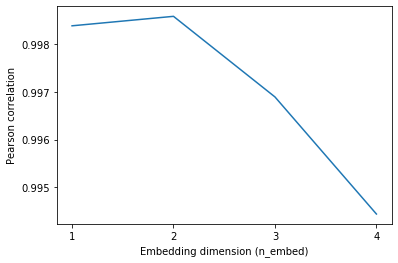

In [123]:
plt.plot(np.arange(1,5),nonlinear_reconstr_cor[:5])
plt.xticks(np.arange(1,5))
plt.xlabel('Embedding dimension (n_embed)')
plt.ylabel('Pearson correlation')

The best embedding dimension is 2!
Now visualize the results and check where the highest errors are

Text(0, 0.5, 'Prediction Data')

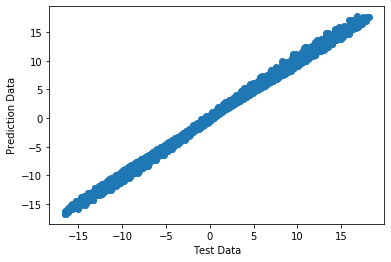

In [124]:
n_embed = 2

# prediction using optimal n_embed
X = embed_vectors_1d(lorenz[:,0],n_embed)
  
# split train/test  
X_train, X_test = train_test_split(X,fraction_train=0.7)

# nonlinear prediction on individual time series
x_p = nonlinear_prediction(X_train, X_test, n_embed)

# simply check correlation of
nonlinear_reconstr_cor.append(np.corrcoef(X_test[:,-1], x_p)[0,1])

# scatter plot real vs predicted
plt.scatter(X_test[:,-1], x_p)
plt.xlabel('Test Data')
plt.ylabel('Prediction Data')

Are errors higher where the gradient is higher? Yes!

Text(0, 0.5, 'Abs. Prediction Error')

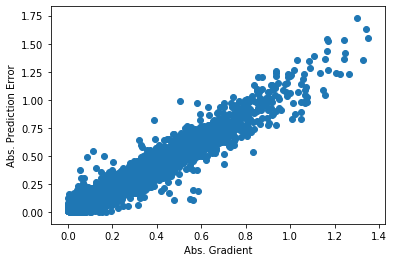

In [132]:
plt.scatter(np.abs(np.gradient(X_test[:,-1])), np.abs(X_test[:,-1]- x_p))
plt.xlabel('Abs. Gradient')
plt.ylabel('Abs. Prediction Error')